# Lab Six: CNNs

Team: Mike Wisniewski

In [1]:
import glob
import numpy as np
import matplotlib.image as img
import matplotlib.pyplot as plt
import tensorflow as tf
from skimage import io
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Flatten
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from PIL import Image, ImageOps
import gc

In [3]:
# get a list of all picture paths
tumor = list(glob.glob('lab6_dataset/tumor/*'))
normal = list(glob.glob('lab6_dataset/normal/*'))

In [4]:
# create a dictionary that holds labels and paths for each image type
df_images = {
    'tumor' : tumor,
    'normal' : normal
}

Text(0.5, 1.0, 'normal')

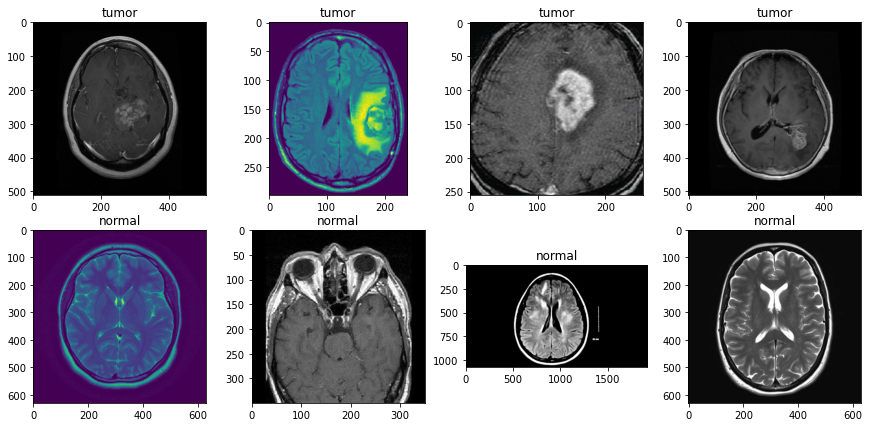

In [5]:
# plot out an image to see what it looks like
fig, ax = plt.subplots(ncols=4, nrows=2, figsize=(10,10))
fig.set_size_inches(15, 7)

ax[0][0].imshow(img.imread(tumor[0]))
ax[0][1].imshow(img.imread(tumor[1]))
ax[0][2].imshow(img.imread(tumor[2]))
ax[0][3].imshow(img.imread(tumor[3]))
ax[1][0].imshow(img.imread(normal[0]))
ax[1][1].imshow(img.imread(normal[1]))
ax[1][2].imshow(img.imread(normal[2]))
ax[1][3].imshow(img.imread(normal[3]))
ax[0][0].set_title("tumor")
ax[0][1].set_title("tumor")
ax[0][2].set_title("tumor")
ax[0][3].set_title("tumor")
ax[1][0].set_title("normal")
ax[1][1].set_title("normal")
ax[1][2].set_title("normal")
ax[1][3].set_title("normal")

NOTE: The lowest image was 167, 175 therefore we reduce the image size down to 150, 150

In [6]:
# read in the datasets and labels
dataset, labels = [], []

for label, images in df_images.items():
    for image in images:
        
        # we do a try because some images got corrupted and come back as 0x0 matrices
        try:
            # read in image as grayscale and resize image down to 150 x 150
            arr = Image.open(image)
            arr = np.asarray(ImageOps.grayscale(arr).resize((64, 64)))
            
            # append to dataset array
            dataset.append(arr)
            
            # extract labels
            labels.append(label)
        except AttributeError:
            pass
        
# convert dataset to numpy array
dataset = np.array(dataset)

# expand the dimensions to include the channel dimension (grayscale)
dataset = np.expand_dims(dataset, 3)

Text(0.5, 1.0, 'normal')

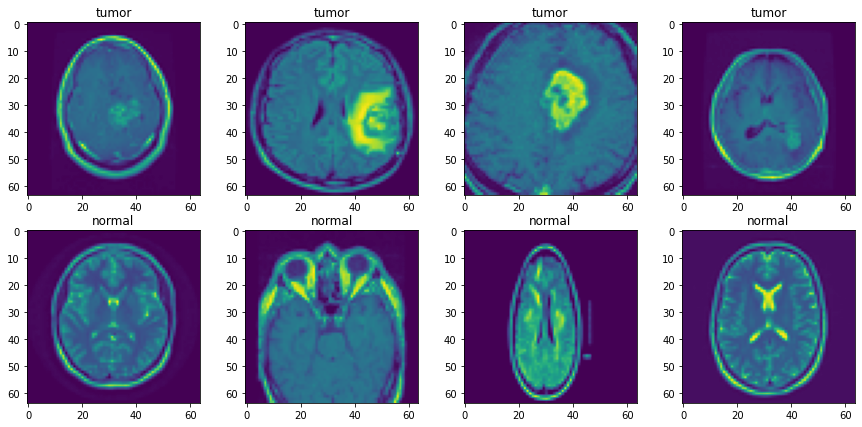

In [7]:
# plot out an image to see what it looks like
fig, ax = plt.subplots(ncols=4, nrows=2, figsize=(10,10))
fig.set_size_inches(15, 7)

ax[0][0].imshow(dataset[0])
ax[0][1].imshow(dataset[1])
ax[0][2].imshow(dataset[2])
ax[0][3].imshow(dataset[3])
ax[1][0].imshow(dataset[2513])
ax[1][1].imshow(dataset[2514])
ax[1][2].imshow(dataset[2515])
ax[1][3].imshow(dataset[2516])
ax[0][0].set_title("tumor")
ax[0][1].set_title("tumor")
ax[0][2].set_title("tumor")
ax[0][3].set_title("tumor")
ax[1][0].set_title("normal")
ax[1][1].set_title("normal")
ax[1][2].set_title("normal")
ax[1][3].set_title("normal")

In [8]:
# describe the dataset
shape_of_dataset = dataset.shape
n_samples = dataset.shape[0]
n_features = dataset.shape[1]**2
classes = np.unique(labels)
n_classes = len(classes)

print("The shape of our dataset:", f'{shape_of_dataset}')
print("The number of samples in our dataset:", f'{n_samples}')
print("The number of features in our dataset:", f'{n_features}')
print("The number of classes in our dataset:", f'{n_classes}')
print("The classes are:", f'{classes}')

The shape of our dataset: (4600, 64, 64, 1)
The number of samples in our dataset: 4600
The number of features in our dataset: 4096
The number of classes in our dataset: 2
The classes are: ['normal' 'tumor']


> [1.5 points] Choose and explain what metric(s) you will use to evaluate your algorithm’s performance. You should give a detailed argument for why this (these) metric(s) are appropriate on your data. That is, why is the metric appropriate for the task (e.g., in terms of the business case for the task). Please note: rarely is accuracy the best evaluation metric to use. Think deeply about an appropriate measure of performance.



Our metrics of choice in order of importance for our model:

   - F1 Score
   - Precision
   - Accuracy
   
Similar to lab 5, I have helper functions defined below to assist in extracting and plotting our important metrics.

In [9]:
def plot_metrics(scores):
    # plot out loss plus metrics
    plt.figure(figsize=(15,15))
    
    plt.subplot(5,2,1)
    plt.title('Training')
    for score in scores:
        plt.plot(score["binary_crossentropy"])
    plt.ylabel('Binary Cross Entropy Loss')
    plt.legend([1,2,3,4,5])
    
    plt.subplot(5,2,3)
    for score in scores:
        plt.plot(score["mean_squared_error"])
    plt.ylabel('MSE Loss')
    
    plt.subplot(5,2,5)
    for score in scores:
        plt.plot(score["precision"])
    plt.ylabel('Precision')
    
    plt.subplot(5,2,7)
    for score in scores:
        plt.plot(score["auc"])
    plt.ylabel('AUC')
    
    plt.subplot(5,2,9)
    for score in scores:
        plt.plot(score["Accuracy"])
    plt.ylabel('Accuracy')
    
    plt.subplot(5,2,2)
    plt.title('Validation')
    for score in scores:
        plt.plot(score["val_binary_crossentropy"])
        
    plt.subplot(5,2,4)
    for score in scores:
        plt.plot(score["val_mean_squared_error"])

    plt.subplot(5,2,6)
    for score in scores:
        plt.plot(score["val_precision"])

    plt.subplot(5,2,8)
    for score in scores:
        plt.plot(score["val_auc"])
        
    plt.subplot(5,2,10)
    for score in scores:
        plt.plot(score["val_Accuracy"])
        
    model_ = 1
    avg_val_precision = []
    for score in scores:
        print(f"Model {model_} Validation Precision:", sum(score["val_precision"])/len(score["val_precision"]))
        avg_val_precision.append(sum(score["val_precision"])/len(score["val_precision"]))
        model_ += 1
        
    print(f"Average Model Validation Precision:", sum(avg_val_precision)/len(avg_val_precision))

In [10]:
def plot_cf_matrix(model, X_test, y_test):
    # predict y using the test dataset
    yhat_proba = model.predict(X_test)
    yhat = np.round(yhat_proba)

    # assess the precision and f1_scores
    print(mt.confusion_matrix(y_test,yhat))
    print(mt.classification_report(y_test,yhat))

> [1.5 points] Choose the method you will use for dividing your data into training and testing (i.e., are you using Stratified 10-fold cross validation? Shuffle splits? Why?). Explain why your chosen method is appropriate or use more than one method as appropriate. Convince me that your cross validation method is a realistic mirroring of how an algorithm would be used in practice.

In [11]:
# shuffle the dataset as it was read in order of tumor and then normal
from sklearn.utils import shuffle
np.random.seed(42)
dataset, labels = shuffle(dataset, labels)

In [12]:
# initialize our X, y (data, labels) - used throughout this notebook
X = []
X_scaled = []
y = labels

"""
Following section we will perform the following operations:
    1. Intialize a scaler
    2. Iterate through each image
    3. Flatten each image
    4. Scale each image
    5. Reshape each image back into original shape (256, 256, 1)
"""

# 1. initialize scaler
scaler = StandardScaler()

# 2. iterate through each image
for image in dataset:
    
    # 3. flatten image
    img = image.ravel()
    
    # append to X
    X.append(img)
    
# 4. scale dataset
X = scaler.fit_transform(X)

for image in X:
    
    # 5. Reshape each image back to original shape
    img = image.reshape(64, 64, 1)
    
    # append to X_scaled
    X_scaled.append(img)

# encode y labels
encoder = LabelEncoder()
y_ohe = encoder.fit_transform(y)

# extract X_scaled from inside list
X_scaled = np.asarray(X_scaled)

In [13]:
# split X and y into train, test
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_ohe, test_size=0.2, random_state=42, stratify=y)

In [14]:
# from sklearn.model_selection import cross_val_score
# from sklearn.model_selection import KFold, ShuffleSplit
# from sklearn.model_selection import StratifiedKFold, StratifiedShuffleSplit

# from sklearn.metrics import make_scorer, accuracy_score
# from sklearn.metrics import precision_score, recall_score, f1_score

# from sklearn.linear_model import LogisticRegression

# # select a model to roughly estimate cv scores
# clf = LogisticRegression()

# # select cross validation
# cv = ShuffleSplit(n_splits=10)

# # select evaluation criteria
# my_scorer = make_scorer(precision_score)  # using recall as the scoring criteria

# # run model training and cross validation
# per_fold_eval_criteria = cross_val_score(estimator=clf,
#                                     X=X,
#                                     y=y,
#                                     cv=cv,
#                                     scoring=my_scorer
#                                    )

# plt.bar(range(len(per_fold_eval_criteria)),per_fold_eval_criteria)
# plt.ylim([min(per_fold_eval_criteria)-0.01,max(per_fold_eval_criteria)])
# print("Average Precision:", np.mean(per_fold_eval_criteria))

> [1.5 points]  Setup the training to use data expansion in Keras (also called data augmentation). Explain why the chosen data expansion techniques are appropriate for your dataset. You can use the keras ImageGenerator as a pre-processing step OR in the optimization loop. You can also use the Keras-cv augmenter (a separate package: https://keras.io/keras_cv/ Links to an external site.)

In [15]:
# initialize Image Data Generator
datagen = ImageDataGenerator(
    featurewise_center=False,
    samplewise_center=False,
    featurewise_std_normalization=False,
    samplewise_std_normalization=False,
    zca_whitening=False,
    rotation_range=5, # used, Int. Degree range for random rotations.
    width_shift_range=0.1, # used, Float (fraction of total width). Range for random horizontal shifts.
    height_shift_range=0.1, # used,  Float (fraction of total height). Range for random vertical shifts.
    shear_range=0., # Float. Shear Intensity (Shear angle in counter-clockwise direction as radians)
    zoom_range=0.,
    channel_shift_range=0.,
    fill_mode='nearest',
    cval=0.,
    horizontal_flip=True,
    vertical_flip=False,
    rescale=None)

# fit the data on train
datagen.fit(X_train)

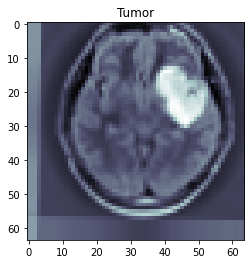

In [16]:
# print out an example of a generated image
tmps = datagen.flow(X_train, y_train, batch_size=1)

for tmp in tmps:
    plt.imshow(tmp[0].squeeze(),cmap='bone')
    if tmp[1][0] == 0:
        plt.title("Normal")
    else:
        plt.title("Tumor")
    break

> [2 points] Create a convolutional neural network to use on your data using Keras. Investigate at least two different convolutional network architectures (and investigate changing some parameters of each architecture such as the number of filters--at minimum have two variations of each network for a total of four models trained). Use the method of train/test splitting and evaluation metric that you argued for at the beginning of the lab. Visualize the performance of the training and validation sets per iteration (use the "history" parameter of Keras). Be sure that models converge. 

In [17]:
# DEFINE MODEL PARAMETERS


In [18]:
gc.collect()

3129

In [ ]:
cnn = Sequential()

# let's start with an AlexNet style convolutional phase
cnn.add(Conv2D(filters=32,
                input_shape = (64,64,1),
                kernel_size=(3,3), 
                padding='same', 
                activation='relu', data_format="channels_last")) # more compact syntax

# # no max pool before next conv layer!!
# cnn.add(Conv2D(filters=64,
#                 kernel_size=(3,3), 
#                 padding='same', 
#                 activation='relu')) # more compact syntax
cnn.add(MaxPooling2D(pool_size=(2, 2), data_format="channels_last"))
    

# add one layer on flattened output
cnn.add(Dropout(0.25)) # add some dropout for regularization after conv layers
cnn.add(Flatten())
cnn.add(Dense(128, activation='relu'))
cnn.add(Dropout(0.5)) # add some dropout for regularization, again!
cnn.add(Dense(1, activation='sigmoid'))

# Let's train the model 
cnn.compile(loss='binary_crossentropy', # 'categorical_crossentropy' 'mean_squared_error'
              optimizer='rmsprop', # 'adadelta' 'rmsprop'
              metrics=['accuracy'])

# the flow method yields batches of images indefinitely, with the given transformations
cnn.fit(datagen.flow(X_train, y_train, batch_size=1), 
                   steps_per_epoch=int(len(X_train)/128), # how many generators to go through per epoch
                   epochs=5, verbose=1,
                   validation_data=(X_test,y_test)
                  )


Epoch 1/5


> [1.5 points] Visualize the final results of the CNNs and interpret/compare the performances. Use proper statistics as appropriate, especially for comparing models. 

> [1 points] Compare the performance of your convolutional network to a standard multi-layer perceptron (MLP) using the receiver operating characteristic and area under the curve. Use proper statistical comparison techniques. 

> One idea (required for 7000 level students): Use transfer learning to pre-train the weights of your initial layers of your CNN. Compare the performance when using transfer learning to training without transfer learning (i.e., compare to your best model from above) in terms of classification performance. 